## Instrumental Broadening


In [15]:
import numpy as np
import matplotlib.pyplot as plt

from broadpy import InstrumentalBroadening

In [16]:
# load PHOENIX model (R~1e6)
wave, flux = np.loadtxt('data/models_Teff_4300_logg_4.0_Z_+0.0.txt').T # T=4300K, logg=4.0, solar metallicity
# select wavelength region in nm
wave_range = (2320.0, 2330.0)
mask = (wave >= wave_range[0]) & (wave <= wave_range[1])
assert np.any(mask), 'No data in the selected wavelength range'
wave = wave[mask]
flux = flux[mask]

for this notebook, `PyAstronomy` must be installed. You can install it by running the following command:
```bash
pip install PyAstronomy
```

In [17]:
# apply instrumental broadening with a Gaussian profile using PyAstronomy
# high resolution
R = 1e5 # resolving power, fwhm = 3 km/s

from PyAstronomy import pyasl
flux_pyasl = pyasl.instrBroadGaussFast(wave, flux, R)

`broadpy` can apply instrumental broadening given the instrumental resolution or the FWHM in km/s,

In [18]:
flux_broadpy = InstrumentalBroadening(wave, flux)(out_res=R, kernel='gaussian')
# or equivalently
flux_broadpy_fwhm = InstrumentalBroadening(wave, flux)(fwhm=2.998e5/R, kernel='gaussian')
assert np.allclose(flux_broadpy, flux_broadpy_fwhm)

<!-- ### Broadening with Gaussian profile using `broadpy`
The class `InstrumentalBroadening` can be called to broaden a spectrum profiles of `gaussian, lorentzian, voigt` type. The class has the following methods:
- Gaussian, two equivalent options passing the resolution or the FWHM [km/s]:
    - ``InstrumentalBroadening(wave, flux)(out_res=1e5, kernel='gaussian')``
    - ``InstrumentalBroadening(wave, flux)(fwhm=(2.998e5/1e5), kernel='gaussian')``

- Lorentzian, passing the width $\Gamma$ [km/s]:
    - ``InstrumentalBroadening(wave, flux)(gamma=2.998e5/1e5, kernel='lorentzian')``
- Voigt, passing the FWHM [km/s] and the Lorentzian width $\Gamma$ [km/s]:
    - ``InstrumentalBroadening(wave, flux)(fwhm=2.998e5/1e5, gamma=2.998e5/1e5, kernel='voigt')`` -->

### Comparison with `PyAstronomy`

 Good agreement down to ~6.7e-06 in the residuals!
 Note the difference at the edges due to the different handling of the convolution.


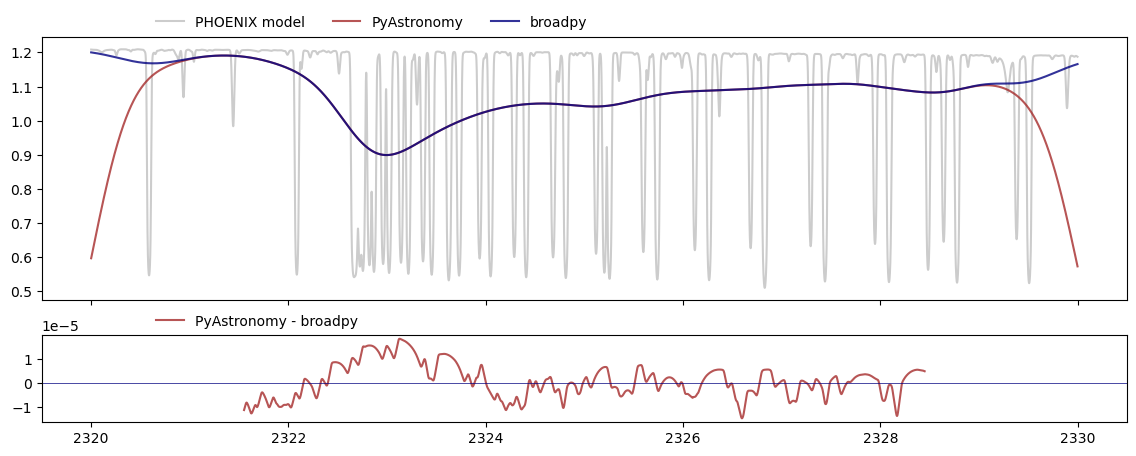

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(14, 5), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax[0].plot(wave, flux, label='PHOENIX model', alpha=0.2, color='k')
ax[0].plot(wave, flux_pyasl, label='PyAstronomy', color='brown', alpha=0.8)
ax[0].plot(wave, flux_broadpy, label='broadpy', color='navy', alpha=0.8)

residuals = flux_pyasl - flux_broadpy
# ignore edges, pyasl does not handle them well
n_edge = 2 * int(np.mean(wave) / np.mean(np.diff(wave)) / R)
residuals[:n_edge] = residuals[-n_edge:] = np.nan

print(f' Good agreement down to ~{np.nanstd(residuals):.1e} in the residuals!')
print(f' Note the difference at the edges due to the different handling of the convolution.')

ax[1].plot(wave, residuals, color='brown', alpha=0.8, label='PyAstronomy - broadpy')
ax[1].axhline(0, color='navy', ls='-', lw=0.5)
[ax_.legend(ncol=3, loc=(0.1, 1.01), frameon=False) for ax_ in ax]
plt.show()


In [20]:
# speed comparison
speed_test = True

if speed_test:
    %timeit pyasl.instrBroadGaussFast(wave, flux, R)
    %timeit InstrumentalBroadening(wave, flux)(out_res=R, kernel='gaussian')

74.2 ms ± 4.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
5.82 ms ± 25.1 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Line profiles: Gaussian, Lorentzian, and Voigt
The line profiles are defined as follows:
- Gaussian:
$$ 
G(x) = \frac{1}{\sqrt{2\pi}\sigma} \exp\left(-\frac{x^2}{2\sigma^2}\right)
$$
- Lorentzian:
$$
L(x) = \frac{1}{\pi} \frac{\gamma}{\gamma^2 + x^2}
$$
- Voigt:
$$
V(x) = \frac{a}{\sigma\sqrt{2\pi}} \exp\left(-\frac{x^2}{2\sigma^2}\right) \ast \left(\frac{1}{\pi} \frac{\gamma}{\gamma^2 + x^2}\right)
$$
where $x$ is the distance from the line center, $\sigma$ is the standard deviation of the Gaussian, $\gamma$ is the Lorentzian width, and $a$ is the area under the curve. Note that normalization factors are irrelevant for the convolution because we normalize the kernel to the area of 1.

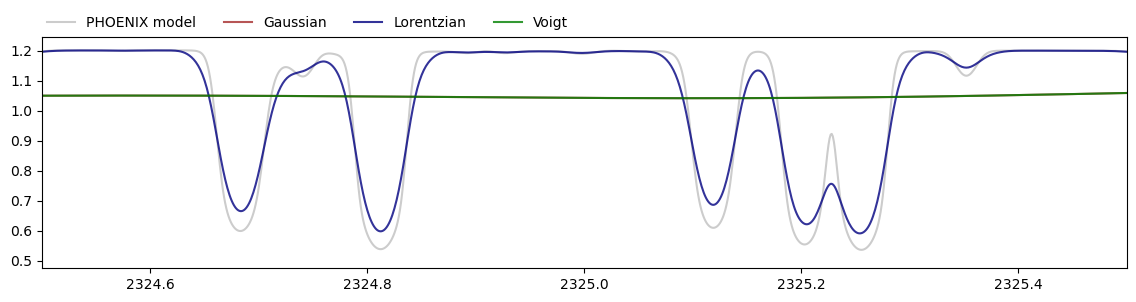

 Gaussian broadening produces depper line cores and narrower wings than Lorentzian broadening.
 [WARNING] Voigt profile in experimental stage, use with caution!


In [21]:
IB = InstrumentalBroadening(wave, flux)
fwhm = 2.998e5/R
# analytic relation between fwhm and lorenzian gamma: FWHM = 2 * gamma
# gamma = 0.5 * fwhm
gamma = 1.0 # km/s
flux_g = IB(fwhm=fwhm, kernel='gaussian')
flux_l = IB(gamma=gamma, kernel='lorentzian')
flux_v = IB(fwhm=fwhm, gamma=gamma, kernel='voigt')

fig, ax = plt.subplots(1, 1, figsize=(14, 3))
ax.plot(wave, flux, label='PHOENIX model', alpha=0.2, color='k')
ax.plot(wave, flux_g, label='Gaussian', color='brown', alpha=0.8)
ax.plot(wave, flux_l, label='Lorentzian', color='navy', alpha=0.8)
ax.plot(wave, flux_v, label='Voigt', color='green', alpha=0.8)
ax.legend(ncol=4, loc=(0.0, 1.01), frameon=False)

# zoom in
ax.set(xlim=np.quantile(wave, [0.45, 0.55]))
plt.show()

print(f' Gaussian broadening produces depper line cores and narrower wings than Lorentzian broadening.')
print(f' [WARNING] Voigt profile in experimental stage, use with caution!')